In [2]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [3]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [4]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [5]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

20 950 0.0 11025 [None] 20


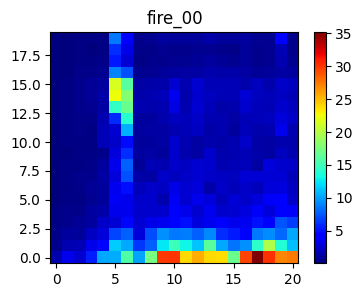

In [ ]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

idx = 0
myds.display(["fire", idx])

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [ ]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire", 0])  # number of items in a feature vector
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
nlearn = round(naudio * train_pct)  # number of sounds among naudio for training
data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)
print(class_ids_aug)

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx]
            X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)



X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

print(
    "Remember the convention shown for the toy example, the feature vectors are arranged on the rows."
)

Shape of the feature matrix : (200, 400)
Number of labels : 200
Remember the convention shown for the toy example, the feature vectors are arranged on the rows.


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [8]:
### TO RUN
K = 10  # Number of neighbours for the KNN
model_knn = KNeighborsClassifier(
    n_neighbors=K, weights="distance", algorithm="auto", metric="minkowski"
)  # We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
)  # We explicitly write the default parameters of this LDA classifier once so that you know they exist and can be changed

As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

Shape of the training matrix : (140, 400)
Number of training labels : 140
Accuracy of KNN with fixed train/validation sets : 56.7%


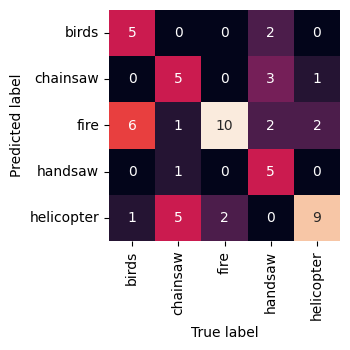

Accuracy of LDA with fixed train/validation sets : 33.3%


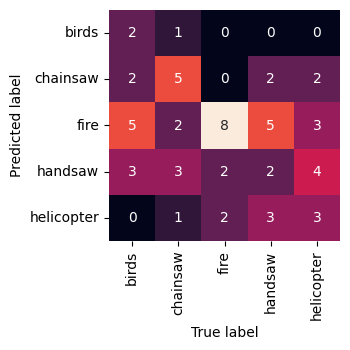

In [9]:
### TO RUN
"Shuffle then split the dataset into training and testing subsets"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)  # random_state=1
print(f"Shape of the training matrix : {X_train.shape}")
print(f"Number of training labels : {len(y_train)}")

model_knn.fit(X_train, y_train)
model_lda.fit(X_train, y_train)

prediction_knn = model_knn.predict(X_test)
prediction_lda = model_lda.predict(X_test)
accuracy_knn = accuracy(prediction_knn, y_test)
accuracy_lda = accuracy(prediction_lda, y_test)

print(f"Accuracy of KNN with fixed train/validation sets : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_test, classnames)
print(f"Accuracy of LDA with fixed train/validation sets : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_test, classnames)

**Questions**: 
- What would be the expected accuracy if the label predictions were picked at random?
- What do you observe in this confusion matrix? Run again the cell above, i.e., Reapply the ``train_test_split`` and tell if your observations are robust.

In [10]:
# 
# Answer the questions above

# 1. What would be the expected accuracy if the label predictions were picked at random?

# If the label predictions were picked at random, the expected accuracy would be the reciprocal of the number of classes.
# In this case, there are 5 classes, so the expected accuracy would be 1/5 or 20%.

# 2. What do you observe in this confusion matrix? Run again the cell above, i.e., Reapply the train_test_split and tell if your observations are robust.
# The accuracy varies a lot at each run for both classifiers. The diagonal is never dominant for LDA, which means that the classifier is not able to predict the correct class for the test data. 
# On average KNN has a better accuracy than LDA, but it is still not very high. The confusion matrix is not robust, as the accuracy varies a lot at each run.


Play with the ``classname`` and the index ``idx`` to pick feature vectors in the dataset ``myds``, listen to the audio associated to the feature vector, and check if you would have been able to predict the right class by your own. Then compare with the prediction given by your classifier.

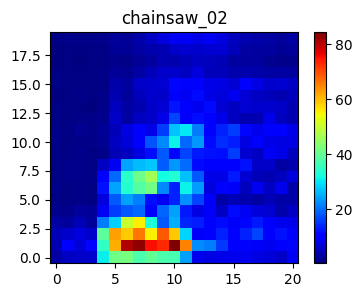

Class predicted by KNN: chainsaw
Class predicted by LDA: chainsaw


In [11]:
### TO RUN
idx = 2
classname = "chainsaw"
myds.display([classname, idx])
thisfv = myds[classname, idx].reshape(-1)

# this artefact is necessary because the 'predict' function expects a matrix_like input.
mat = np.zeros((2, len(thisfv)))
mat[0] = thisfv

prediction_knn = model_knn.predict(mat)
prediction_lda = model_lda.predict(mat)

print("Class predicted by KNN:", prediction_knn[0])
print("Class predicted by LDA:", prediction_lda[0])

Furthermore, when training a model and comparing different settings, there is a risk that we will end up choosing optimal parameters that only render good result on our specific case of training and validation set, but ``do not generalize well for additional data``. This is called ``overfitting on the validation set``. To alleviate this, we can perform ``cross-validation (CV)``. A basic approach named ``K-fold CV`` involves partitioning the dataset in ``K`` "folds" (subsets) and repetitvely do the following procedure:

- Train the model using `K-1` folds as the training data.
- Test the model using the last fold as the validation data.

The overall performance on each fold is then averaged to obtain the final performance metrics.

In [12]:
### TO RUN
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

accuracy_knn = np.zeros((n_splits,))
accuracy_lda = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train, y_train)):
    (idx_learn, idx_val) = idx
    model_knn.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_knn = model_knn.predict(X_train[idx_val])
    accuracy_knn[k] = accuracy(prediction_knn, y_train[idx_val])

    model_lda.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_lda = model_lda.predict(X_train[idx_val])
    accuracy_lda[k] = accuracy(prediction_lda, y_train[idx_val])

print(f"Mean accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.mean():.1f}%")
print(
    f"Std deviation in accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.std():.1f}%"
)

print(f"Mean accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.mean():.1f}%")
print(
    f"Std deviation in accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.std():.1f}%"
)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


Mean accuracy of KNN with 5-Fold CV: 50.7%
Std deviation in accuracy of KNN with 5-Fold CV: 3.5%
Mean accuracy of LDA with 5-Fold CV: 39.3%
Std deviation in accuracy of LDA with 5-Fold CV: 9.3%


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


<font size=5 color=#009999> 2.3. Scale mismatch and countermeasure </font> <br>

In real conditions, you will most probably have a different scale between the feature vectors used for training (in simulation) and the ones you feed in your model to make predictions.
This scale mismatch between model training and prediction is difficult to prevent because it depends on multiple factors such as the audio source power, its distance to the microphone, the telecommunication distance. <br>

Below, we illustrate the link between the volume of the audio and its distance to the origin of the feature space. At different emission distances, the exact same sound would be heard at a different volume and the associated feature vector would be located at another position in the *feature space*. Eventually, this would result in a completely different classification, which is undesirable.

<center> <img src="figs/norms.png" alt="" width="350"/> </center>

### Questions:

- How could you avoid this dependency on the volume of the sound?
- What is represented in the hatched centered area? How would you classify feature vectors in this area?

In [13]:
# Answer the questions above

# 1. How could you avoid this dependency on the volume of the sound?
# One way to avoid this dependency is to normalize the feature vectors so that they have a unit norm.
# This way, the classification will be based on the direction of the feature vector rather than its magnitude, which is influenced by the volume of the sound.

# 2. What is represented in the hatched centered area? How would you classify feature vectors in this area?
# The hatched centered area represents the region where the feature vectors have very low magnitudes, which could correspond to silence or very low volume sounds.
# => use a threshold to filter out these low-magnitude vectors before classification.

Play with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

On which part of the dataset are we computing this confusion matrix?

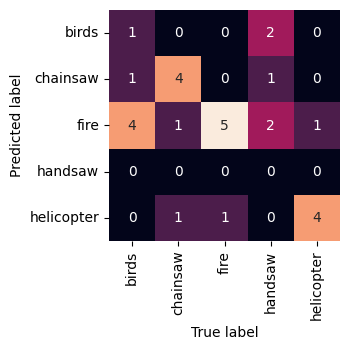

Accuracy of KNN: 50.0%


In [14]:
### TO RUN
dB_mismatch = 0  # Play with this value
X_val_scaled = X_train[idx_val] * 10 ** (-dB_mismatch / 20)

model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train[idx_learn], y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_scaled)
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])
print(f"Accuracy of KNN: {100 * accuracy_knn:.1f}%")


The simplest countermeasure we can think of is to normalise the feature vector (i.e. unitize its norm) prior to use, both for training and testing. Remember how this normalization could be visualized in ``hands_on_classif1_toy_student.ipynb`` <br>
Play again with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

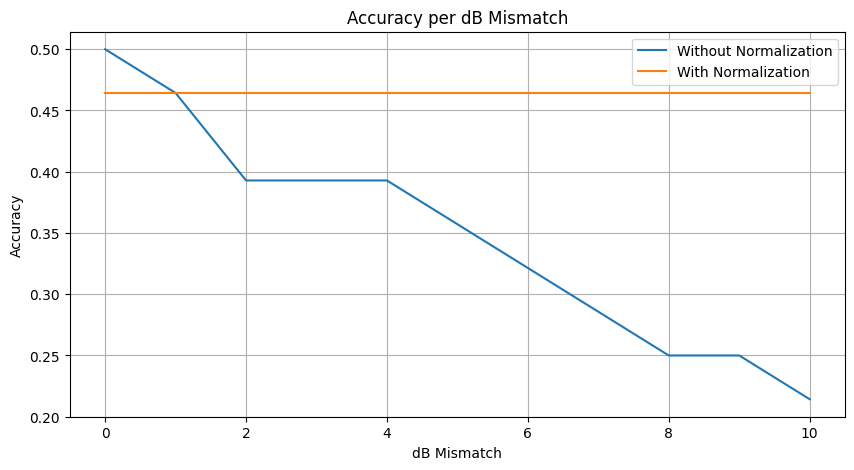

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score as accuracy

# Define a range of dB mismatch values
dB_mismatches = np.arange(0, 11, 1)

precisions = []
precisions_normalized = []

for dB_mismatch in dB_mismatches:
    # Scale validation set with dB mismatch
    X_val_scaled = X_train[idx_val] * 10 ** (-dB_mismatch / 20)
    
    # Train and predict without normalization
    model_knn = KNeighborsClassifier(n_neighbors=10)
    model_knn.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_knn = model_knn.predict(X_val_scaled)
    accuracy_knn = accuracy(prediction_knn, y_train[idx_val])
    precisions.append(accuracy_knn)
    
    # Normalize training and validation sets
    X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
    X_val_normalized = X_val_scaled / np.linalg.norm(X_val_scaled, axis=1, keepdims=True)
    
    # Train and predict with normalization
    model_knn.fit(X_train_normalized[idx_learn], y_train[idx_learn])
    prediction_knn_normalized = model_knn.predict(X_val_normalized)
    precision_normalized = accuracy(prediction_knn_normalized, y_train[idx_val])
    precisions_normalized.append(precision_normalized)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(dB_mismatches, precisions, label='Without Normalization')
plt.plot(dB_mismatches, precisions_normalized, label='With Normalization')
plt.xlabel('dB Mismatch')
plt.ylabel('Accuracy')
plt.title('Accuracy per dB Mismatch')
plt.legend()
plt.grid(True)
plt.show()

**Question**: 
- What will happen with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could you deal with it?

In [16]:
# Answer the questions above

# 1. What will happen with this normalisation countermeasure when there is no sound around the microphone? 
# When there is no sound around the microphone, the feature vector will have very low magnitudes, 
# This can lead to misleading classification results as the classifier might interpret the normalized noise as a valid feature vector.

# 2. Is this desirable?
# No =>  incorrect classifications and reduced accuracy.

# 3. How could you deal with it?
# We could use a threshold to filter out the low-magnitude vectors before classification. before or after normalisation.

<font size=5 color=#009999> 2.4. Dimensionality reduction </font> <br>

It is sometimes good practice to reduce the dimensionality of a signal in order to get the main components of their distribution. A motivation is that usual norms behave counter-inuitively in high dimension. It also further reduces the memory cost of the feature vector. To reduce the dimensionality, we will use the ``Principal component analysis (PCA)`` proposed by sklearn. See the [associated Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis). Recall: the PCA consists in reducing the dimensionality of data vectors encoded in $\boldsymbol X \in \mathbb R^{d\times N}$ to only $p \ll d$ dimensions as

$$
    \boldsymbol Y = \boldsymbol V_p^\top \boldsymbol X \in \mathbb R^{p\times N},
$$

where the SVD of the covariance matrix writes as $\hat{\boldsymbol\Sigma}_{\boldsymbol X} = \frac{1}{d} \boldsymbol{XX}^\top = \boldsymbol{U\Sigma V}^\top$, and $\boldsymbol V_p$ is the subselection of the first $p$ columns of $\boldsymbol V$. 

For our application, reducing the dimensionality of the data can be helpful for compressing the packet size to be transmitted wirelessly. Indeed, once learned during training, $\boldsymbol V_p$ can be hardcoded on the transmitter side.

Starting with a PCA to 2D for visualization, see how hard it is to separate the classes.

Shape of the reduced training matrix : (112, 2)


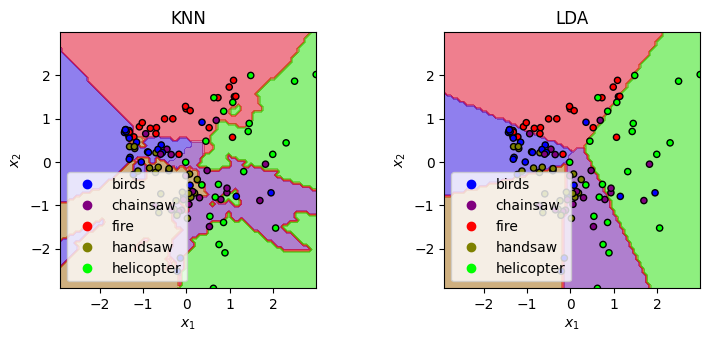

In [17]:
### TO RUN
n = 2  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced training matrix : {X_learn_reduced.shape}")

y_train_num = np.zeros(y_train.shape)
for i, classname in enumerate(classnames):
    y_train_num[y_train == classname] = i

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K)
model_knn.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train_num[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train_num[idx_val])

fig = plt.figure()
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[0],
    model=model_knn,
    legend=classnames,
    title="KNN",
)
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[1],
    model=model_lda,
    legend=classnames,
    title="LDA",
)
plt.show()
#112 = nombre d'échantillons rpz par 2 composantes principales

**Question**: 
- From the decision boundaries shown here above, can you explain why the ``handsaw`` class is less often chosen than the other classes for the ``KNN`` classifier?

In [18]:
# The handsaw class has a lower density and since KNN assigns a class based on the majority of nearby points,
# the "handsaw" class is less likely to dominate a neighborhood. 

#Proximity to other classes, making its points more likely to be misclassified to other classes

#LDA assumes Gaussian distributions and separates classes with linear boundaries based on maximizing the distance between class means.
#As a result, the "handsaw" class gets a larger and more uniform region in the LDA plot compared to KNN.


Shape of the reduced learning matrix : (112, 5)
Accuracy of the KNN : 67.9%


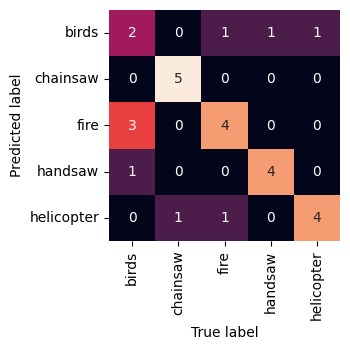

Accuracy of the LDA : 46.4%


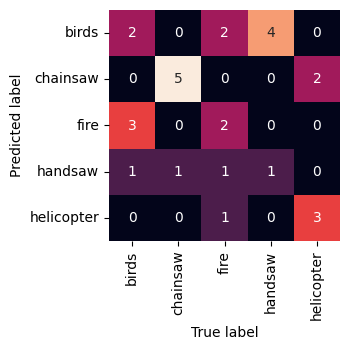

In [19]:
### TO RUN
n = 5  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced learning matrix : {X_learn_reduced.shape}")

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
model_knn.fit(X_learn_reduced, y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train[idx_val])

print(f"Accuracy of the KNN : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
print(f"Accuracy of the LDA : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_train[idx_val], classnames)

<font size=5 color=#009999> 2.5. Analysis of the hyperparameters </font> <br>

Finally, we can inspect the influence of ``hyperparameters`` as we did for the toy example. <br>
Let us start by analyzing the influence of the number of neighbours $K$ in the KNN. 

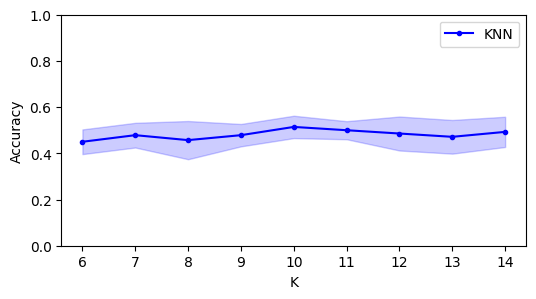

In [20]:
### TO RUN
Ks = np.arange(6, 15, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i, K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
    for k, idx in enumerate(kf.split(X_train, y_train)):
        (idx_learn, idx_val) = idx
        model_knn.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_knn = model_knn.predict(X_train[idx_val])
        accuracies_knn[i, k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6, 3))
plt.plot(Ks, means_knn, ".-b", label="KNN")
plt.fill_between(Ks, means_knn - stds_knn, means_knn + stds_knn, alpha=0.2, color="b")
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here we consider both ``K`` and the number of principal components ``n``.

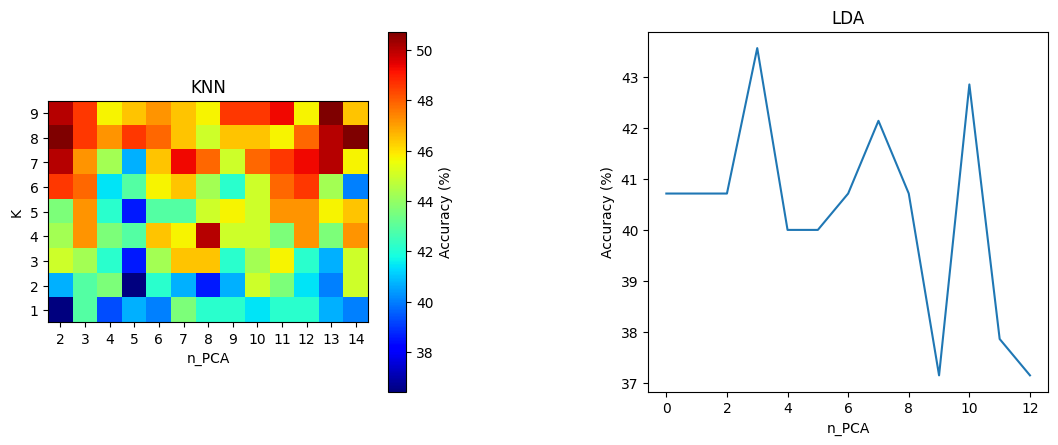

In [21]:
### TO RUN
Ks = np.arange(1, 10)
n_comps = np.arange(2, 15)  # number of principal components kept for the PCA
accuracies_knn = np.zeros((len(Ks), len(n_comps)))
accuracies_lda = np.zeros(len(n_comps))

for j, n in enumerate(n_comps):
    for idx_learn, idx_val in kf.split(X_train, y_train):
        pca = PCA(n_components=n, whiten=True)
        X_learn_reduced = pca.fit_transform(X_train[idx_learn])
        X_val_reduced = pca.transform(X_train[idx_val])
        for i, K in enumerate(Ks):
            model_knn = KNeighborsClassifier(n_neighbors=K)
            model_knn.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_knn = model_knn.predict(X_train[idx_val])
            accuracies_knn[i, j] += accuracy(prediction_knn, y_train[idx_val])

        model_lda = LDA()
        model_lda.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_lda = model_lda.predict(X_train[idx_val])
        accuracies_lda[j] += accuracy(prediction_lda, y_train[idx_val])

accuracies_knn /= n_splits
accuracies_lda /= n_splits

fig = plt.figure(figsize=(10, 4))
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]

im0 = axs[0].imshow(100 * accuracies_knn, cmap="jet", origin="lower")
cbar = fig.colorbar(im0, ax=axs[0])
cbar.set_label("Accuracy (%)")
axs[0].set_xlabel("n_PCA")
axs[0].set_ylabel("K")
axs[0].set_xticks(list(np.arange(len(n_comps))))
axs[0].set_xticklabels(list(n_comps))
axs[0].set_yticks(list(np.arange(len(Ks))))
axs[0].set_yticklabels(list(Ks))
axs[0].set_title("KNN")

axs[1].plot(accuracies_lda * 100)
axs[1].set_xlabel("n_PCA")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("LDA")
plt.show()

**Question**: 
- Do you observe some dependency of the accuracy on these parameters? If so, which one(s)? If not, discuss what it tells about the considered model. 

In [22]:
# Yes, there is a dependency of the accuracy on the parameters K and n_pca.
# For the KNN classifier, the accuracy generally increases with the number of neighbors K up to a certain point, after which it starts to decrease.
# This indicates that a moderate number of neighbors is optimal for this dataset.

# For the LDA classifier, the accuracy does not show significant improvement with the increase in the number of principal components.
# This suggests that LDA may not be the best model for this dataset, as it does not benefit much from the additional components.

#The results highlight that KNN's performance is highly dependent on careful tuning of K 
# LDA is stable and efficient, making it a good choice when simplicity is needed. 
# However, it may not capture the complexity of the data as well as KNN, especially when the data is not linearly separable.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


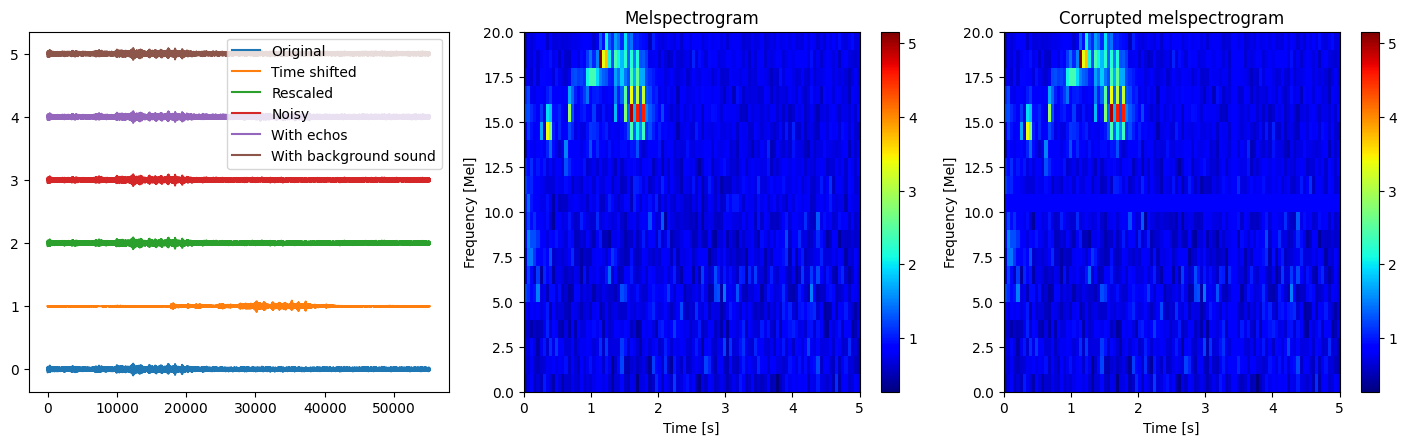

In [23]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["birds", 4]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)

AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.4)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio2, sigma=1e-2)
audio6 = AudioUtil.echo(audio2, 3)
audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [24]:
### TO RUN
myds.mod_data_aug(["add_bg", "echo", "noise", "scaling","time_shift"])
print(classnames)

# Initialisation des matrices de caractéristiques et des étiquettes
X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)

print(f"Shape of the feature matrix : {X_aug.shape}")

# # Génération des vecteurs de caractéristiques et des étiquettes
# for s in range(myds.data_aug_factor):
#     for idx in range(dataset.naudio):
#         for class_idx, classname in enumerate(classnames):
#             featvec = myds[classname, idx]
#             X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
#             y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
# y_aug = np.array(y_aug)

# # Sauvegarde des matrices de caractéristiques
# np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug)
# np.save(fm_dir + "labels_2D_aug.npy", y_aug)

# Chargement des matrices de caractéristiques (si nécessaire)
X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug = np.load(fm_dir + "labels_2D_aug.npy",allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

['birds', 'chainsaw', 'fire', 'handsaw', 'helicopter']
Shape of the feature matrix : (1200, 400)
Shape of the feature matrix : (1000, 400)
Number of labels : 1000


/tmp/ipykernel_5218/797463678.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'All Augmentations'])
/tmp/ipykernel_5218/797463678.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


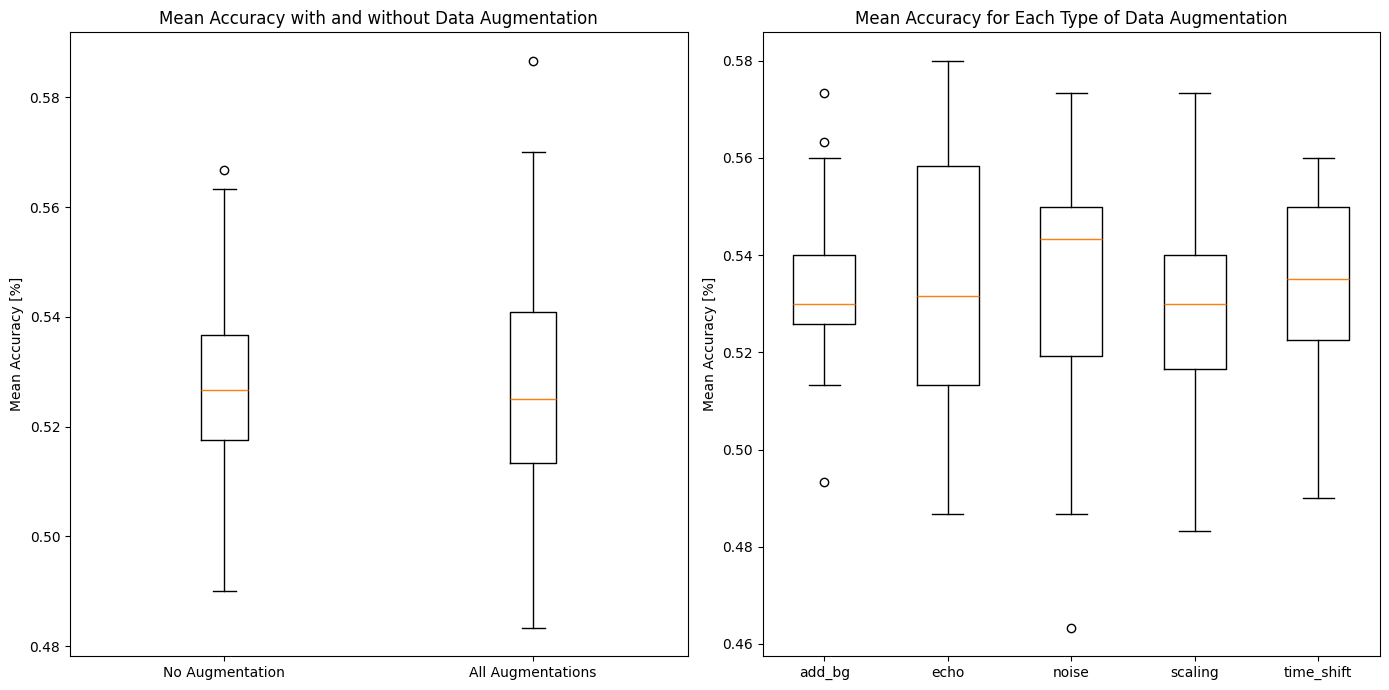

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy

def evaluate_model(X_train, y_train, X_test, y_test):
    model_knn = KNeighborsClassifier(n_neighbors=10)
    model_knn.fit(X_train, y_train)
    predictions = model_knn.predict(X_test)
    return accuracy(y_test, predictions)

# Number of evaluations to perform
n_evaluations = 20

# Evaluate without data augmentation
accuracies_no_aug = []
for _ in range(n_evaluations):
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, stratify=y_aug)
    accuracies_no_aug.append(evaluate_model(X_train, y_train, X_test, y_test))

# Evaluate with all data augmentation
myds.mod_data_aug(["add_bg", "echo", "noise", "scaling","time_shift"])
X_aug_all = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug_all = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)
accuracies_all_aug = []
for _ in range(n_evaluations):
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_aug_all, y_aug_all, test_size=0.3, stratify=y_aug_all)
    accuracies_all_aug.append(evaluate_model(X_train_all, y_train_all, X_test_all, y_test_all))

# Evaluate with individual data augmentations
augmentations = ["add_bg", "echo", "noise", "scaling","time_shift"]
accuracies_individual_aug = {aug: [] for aug in augmentations}

for aug in augmentations:
    myds.mod_data_aug([aug])
    X_aug_individual = np.load(fm_dir + "feature_matrix_2D_aug.npy")
    y_aug_individual = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)
    for _ in range(n_evaluations):
        X_train_individual, X_test_individual, y_train_individual, y_test_individual = train_test_split(X_aug_individual, y_aug_individual, test_size=0.3, stratify=y_aug_individual)
        accuracies_individual_aug[aug].append(evaluate_model(X_train_individual, y_train_individual, X_test_individual, y_test_individual))

# Plot the results
plt.figure(figsize=(14, 7))

# Plot accuracy with and without data augmentation
plt.subplot(1, 2, 1)
plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'All Augmentations'])
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy with and without Data Augmentation')


plt.subplot(1, 2, 2)
plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy for Each Type of Data Augmentation')

plt.tight_layout()
plt.show()

/tmp/ipykernel_5218/2722067172.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'All Augmentations'])
/tmp/ipykernel_5218/2722067172.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


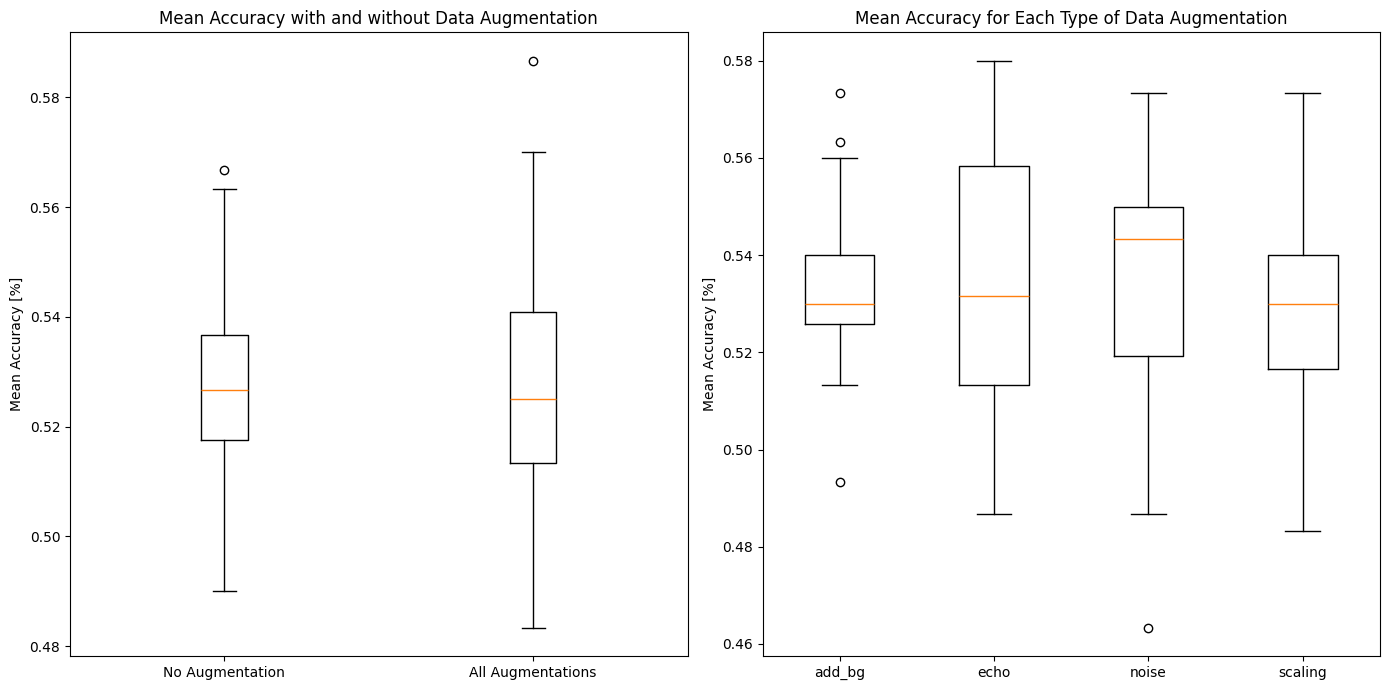

Mean accuracy with 5-Fold CV: 56.3%
Std deviation in accuracy with 5-Fold CV: 1.0%


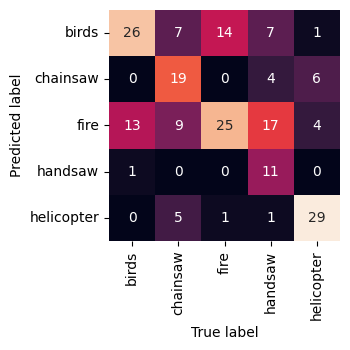

In [26]:
### TO RUN
# Plot the results
plt.figure(figsize=(14, 7))
augmentations = ["add_bg", "echo", "noise", "scaling"]

# Plot accuracy with and without data augmentation
plt.subplot(1, 2, 1)
plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'All Augmentations'])
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy with and without Data Augmentation')


plt.subplot(1, 2, 2)
plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy for Each Type of Data Augmentation')

plt.tight_layout()
plt.show()
# Select from above the best K and n_pca values for the KNN classifier
K = 8  # Number of neighbours
n = 14 # Number of principal components kept
model = KNeighborsClassifier(n_neighbors=K)
pca = PCA(n_components=n, whiten=True)

accuracy_aug = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_aug, y_aug)):
    (idx_train, idx_test) = idx
    model.fit(X_aug[idx_train], y_aug[idx_train])
    prediction_aug = model.predict(X_aug[idx_test])
    accuracy_aug[k] = accuracy(prediction_aug, y_aug[idx_test])

print(f"Mean accuracy with 5-Fold CV: {100 * accuracy_aug.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracy_aug.std():.1f}%")
show_confusion_matrix(prediction_aug, y_aug[idx_test], classnames)
#

**Questions**:
- Can you see an improvement of the classification result compared to the non augmented dataset? Try to interpret your answer by thinking about the distribution of points in a data space (as with the toy example), what does it imply to augment the data in terms of distribution of points in the data space?
- With the ``add_bg`` augmentation technique, where are the additive background signals coming from? It is a good thing?
- What transformations are most likely to be realistic in your application? What is the most efficient way to integrate these alterations in your classification task? ``Hint``: it does not require augmenting your data in Python.

In [27]:
#1. No the mean accuracy of KNN with 5-Fold CV is lower with the augmented dataset than with the non-augmented dataset.
# ~20.0% (augmented) vs 50.0%
# Indeed, augmentation introduces new variations of the data points, which increases the diversity of the dataset but
# also introduces noise that can make the classification task more challenging. The background noise added in the augmentation
# is not a real background sound, it's a random sound that can be very different from the actual background sounds in the dataset.

#2. With the add_bg augmentation, the additive background signals come from the dataset, but from random classes.
# so it can be confusing if the background noise contains features that are also present in the target class, 
# the classifier might struggle to distinguish between the actual signal and the noise. So decrease the accuracy.
# Crucial to differenciate the background noise from the target class but using real background noise 
# that is representative of the environment where the target class is recorded would be more efficient.

#3. Firstly, to remind the normalization should be done before prediction to ensure that the input data to the classifier
# is on the same scale as the data used during training, leading to more accurate and consistent predictions.
# Normalizing after predictions will not correct for differences in the distribution of input data and could
# lead to incorrect or inconsistent predictions.

# So Realistic transformations of the data should be normalization, time shifting could be useful to increase the accuracy 
# by making the classifier more robust delays in the sound signal 
# while scaling could be useful to increase the accuracy by making the classifier more robust to changes in the volume of the sound signal.
# Finally add_bg could be useful if the background noise is representative of the environment where the target class is recorded.


<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

Number of features kept after PCA: 14
Mean accuracy with 8NN 5-Fold CV: 64.3%
Std deviation in accuracy with 5-Fold CV: 3.2%


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


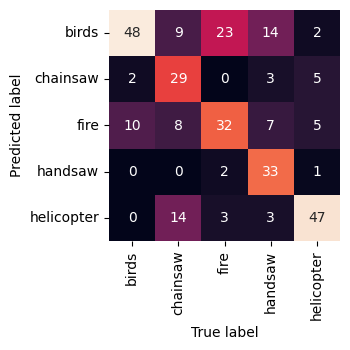

In [ ]:
### TO COMPLETE

# [1] Create dataset of feature vectors and split it.
# (optional) with data augmentation
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.4)
myds.mod_data_aug(["add_bg", "echo", "time_shift", "noise"])

X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)
# # Génération des vecteurs de caractéristiques et des étiquettes
# for s in range(myds.data_aug_factor):
#     for idx in range(dataset.naudio):
#         for class_idx, classname in enumerate(classnames):
#             featvec = myds[classname, idx]
#             X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
#             y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
# y_aug = np.array(y_aug)
# # Sauvegarde des matrices de caractéristiques
# np.save(fm_dir + "feature_matrix_2D_final.npy", X_aug)
# np.save(fm_dir + "labels_2D_final.npy", y_aug)

# Chargement des matrices de caractéristiques (si nécessaire)
X_aug = np.load(fm_dir + "feature_matrix_2D_final.npy")
y_aug = np.load(fm_dir + "labels_2D_final.npy",allow_pickle=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, stratify=y_aug
)  # random_state=1

# [2] (optional) Data normalization
X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalized = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

# [3] (optional) dimensionality reduction.
n = 14  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
print(f"Number of features kept after PCA: {n}")
X_train_normalized = pca.fit_transform(X_train_normalized)
X_test_normalized = pca.transform(X_test_normalized)

# [4] Model training and selection.
K = 8
model = KNeighborsClassifier(n_neighbors=K, weights="distance")

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracies_knn = np.zeros((n_splits,))

for k, idx in enumerate(kf.split(X_train_normalized, y_train)):
    (idx_learn, idx_val) = idx
    model.fit(X_train_normalized[idx_learn], y_train[idx_learn])
    prediction_knn = model.predict(X_train_normalized[idx_val])
    accuracies_knn[k] = accuracy(prediction_knn, y_train[idx_val])


# [5] Save the trained model, eventually the pca.
filename_model = "modeltest.pickle"
filename_pca = "pca.pickle"
pickle.dump(model, open(model_dir + filename_model, "wb"))
pickle.dump(pca, open(model_dir + filename_pca, "wb"))

# [6] Evaluate the model.
print(f"Mean accuracy with 8NN 5-Fold CV: {100 * accuracies_knn.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracies_knn.std():.1f}%")
prediction_knn = model.predict(X_test_normalized)
show_confusion_matrix(prediction_knn, y_test, classnames)



<font size=5 color=#009999> 2.8. Debriefing </font> <br>
**Questions** : 

1) from what we have done in this notebook, can you already identify some weaknesses in the feature vector computation and classification pipeline? You can make a list here below, and eventually write some short ideas for improvement. This will help you later :)
2) Do you remember what is the time duration of a feature vector? What happens if no sound is produced during the acquisition time of a feature vector?

In [29]:
# The number of feature matrices and the number of labels in a dataset can significantly impact the performance of an audio classification model. 
# For instance, in the first audio classification task, it was observed that the "fire" class had characteristics found in multiple signals,
# leading to misclassification into this class. This issue needs to be analyzed further.

# When scaling the data, it is crucial to normalize the entire dataset to ensure consistency. However, care must be taken to ensure that normalization does not reduce accuracy.
# Additionally, adding a noise threshold for the "dump" class can help improve classification performance.

# Finding the best parameters for dimensionality reduction and identifying the optimal feature vector space is essential. 
# This requires good hyperparameter tuning and adapting the complexity of the model to the amount of available data. 
# Data augmentation is also important; recording new sounds with our microphone and MCU, and enhancing the dataset as much as possible by considering real-world scenarios, 
# can significantly improve the model's robustness and accuracy.

In [30]:
# The time duration of a feature vector is not simply the product of nmels and duration. 
# Instead, it depends on the number of Mel bands (nmels), the duration of the audio segment, and the parameters used for STFT 
# such as the window size and hop length. The feature vector represents the audio signal in the time-frequency domain, where nmels 
# is the number of Mel frequency bands and duration is the length of the audio segment in milliseconds.

# When no sound is produced and data normalization is applied, the normalization process could enhance the noise, leading to misclassification. 
# To address this issue, it is important to introduce a "dump" class. This class would be used to classify sounds when their sound level is below a certain threshold,
# effectively filtering out silence and low-level noise. This approach ensures that the classifier can handle cases of silence and low-level noise more effectively, 
# improving overall classification performance.